# Profiling Python Programs

**Lightning Talk**

**Dr. Tom Nurkkala**

**W/03-May-2023**

# Who Cares?

Why should we care about profiling our code?
It gives us a deeper understanding of run-time behavior
and allows us to:

1. Find and eliminate performance bottlenecks
1. Minimize run time
1. Mimimize hosting cost
1. Improve customer experience

# Jupyter

This is a [Jupyter](https://jupyter.org/) notebook.
It's essentially an _executable document_
that can contain **text cells** (like this),
formatted using Markdown, or:

In [1]:
def hello_jupyter():
    print("Code cells (like this)")

which can be executed within the Notebook.
Any value returned by execution of a code cell appears
in a output cell. For example:

In [2]:
hello_jupyter()

Code cells (like this)


A Jupyter notebook usually starts by importing whatever packages
will be needed by the remainder of the notebook.

In [3]:
import functools
import io
import pstats
import time
import random
import math
import pandas as pd
from cProfile import Profile
from datetime import datetime
from dataclasses import dataclass
from enum import Enum
from heapq import merge

# Python Decorator Refresher

From the Python glossary:

> A function returning another function, usually applied as a function transformation using the `@wrapper` syntax

## Simple Decorator

This decorator illustrates the pattern:

1. Accept a function, `func`
1. Wrap `func` with some new behavior
1. Return the wrapped version of the function.

In [4]:
def simple_decorator(func):
    def wrapper():
        print(f"before {func.__name__}")
        func()
        print(f"after {func.__name__}");
    return wrapper

Invoke the decorator using the `@` syntax.
This is synactic sugar for:
```python
print_hello = simple_decorator(print_hello)
```

In [5]:
@simple_decorator
def print_hello(who="world"):
    print(f"hello, {who}")

print_hello()

before print_hello
hello, world
after print_hello


Note that we're not passing any arguments to the wrapped function,
nor are we returning its return value.
In fact, if we invoked the `print_hello` function with an argument
after wrapping it, Python would complain:
```
TypeError: simple_decorator.<locals>.wrapper() takes 0 positional arguments but 1 was given
```
Importantly, the error comes from `wrapper`, which has an empty parameter list.

## Support Arguments, Return Value

Augment the `wrapper` function to expect arbitrary arguments
and to return the value of the wrapped function.

In [6]:
def args_and_vals_decorator(func):
    def wrapper(*args, **kwargs):
        print(f"before {func.__name__}")
        rtn = func(*args, **kwargs)
        print(f"after {func.__name__}");
        return rtn
    return wrapper        

Now we can:

1. Invoke the wrapped function with arguments, which will be passed along to the (wrapped) `return_hello` function.
1. Access the return value from `return_hello`

In [7]:
@args_and_vals_decorator
def return_hello(who="world"):
    return f"hello, {who}"

return_hello("gracie")

before return_hello
after return_hello


'hello, gracie'

## Wrapper Weirdness

By wrapping a function as we have done,
we're losing some information about the wrapped function.
The value of `return_hello` is no longer the function it was defined to be initially:

In [8]:
return_hello

<function __main__.args_and_vals_decorator.<locals>.wrapper(*args, **kwargs)>

Python's `functools` package comes to the rescue,
using Python's considerable introspection powers
to expose the wrapped function from the wrapper itself.

In [9]:
def introspective_decorator(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)

    return wrapper

@introspective_decorator
def double_hello(who="world"):
    return f"hello, hello, {who}"

double_hello("teddy")

'hello, hello, teddy'

Now if we inspect the wrapped function's definition,
we see the underlying `double_hello` function.

In [10]:
double_hello

<function __main__.double_hello(who='world')>

# Simple Timing Decorator

This decorator measures the elapsed time of a single wrapped function
(from [Real Python](https://realpython.com/primer-on-python-decorators/#timing-functions)).
Useful to detect time-consuming functions.

In [11]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")
        return value
    return wrapper_timer

Here's a naive function to calculate the $n^{th}$ Fibonacci number;
it is famously inefficient.
Note that the `@timer` decorator is on a helper function
so that we get only a single result.
If we decorated `dumb_fibonacci` itself,
the decorator would report a time on every recursive call.

In [12]:
def dumb_fibonacci(n: int) -> int:
    if n < 2:
        return 1
    else:
        return dumb_fibonacci(n - 1) + dumb_fibonacci(n - 2)

@timer
def dumb_fib(n: int):
    return dumb_fibonacci(n)

print(dumb_fib(35))

Finished 'dumb_fib' in 1.5375 secs
14930352


A smarter version of the function memoizes (caches) intermediate results.
Compare the timing data.

In [13]:
@functools.cache
def memoized_fibonacci(n: int) -> int:
    if n < 2:
        return 1
    else:
        return memoized_fibonacci(n - 1) + memoized_fibonacci(n - 2)
    
@timer
def memoized_fib(n: int) -> int:
    return memoized_fibonacci(n)

print(memoized_fib(35))

Finished 'memoized_fib' in 0.0000 secs
14930352


# Call Counting Decorator

If detailed timing is not required,
simply counting function invocations can be helpful.
Here's a _class-based_ decorator that does just that
(from [Real Python](https://realpython.com/primer-on-python-decorators/#classes-as-decorators)).
Class-based decorators can be simpler than function-based ones
when the decorator needs to retain state.

In [14]:
class CountCalls:
    def __init__(self, func):
        functools.update_wrapper(self, func)
        self.func = func
        self.num_calls = 0

    def __call__(self, *args, **kwargs):
        self.num_calls += 1
        print(f"Call {self.num_calls} of {self.func.__name__!r}")
        return self.func(*args, **kwargs)

@CountCalls
def classic_hello():
    print("hello, world")

for i in range(7):
    classic_hello()

Call 1 of 'classic_hello'
hello, world
Call 2 of 'classic_hello'
hello, world
Call 3 of 'classic_hello'
hello, world
Call 4 of 'classic_hello'
hello, world
Call 5 of 'classic_hello'
hello, world
Call 6 of 'classic_hello'
hello, world
Call 7 of 'classic_hello'
hello, world


# Profiling Decorator

This decorator of mine captures profiling data 
for the wrapped function 
and all the functions that it invokes (recursively).
It also accepts parameters to customize its behavior:

* `print_report`&mdash;generates a profile report directly to `stdout`
* `save_report`&mdash;captures profile data in a file for later analysis
* `file_name`&mdash;sets the name of the profile data file instead of the default time-stamped file name.

The `Profile` class collects, interprets, and reports the profile data.

The common idiom for accepting parameters in a decorator
is to introduce a _third_ level of function nesting,
as illustrated here.
In the outermost scope, we make use of the arguments passed to the decorator.
We still must observe the normal decorator protocol:
return a function (here, `outer_wrapper`) 
that accepts a function (the wrapped function)
and returns a decorated version.

In [33]:
def profile_function(print_report=False, save_report=True, file_name=None):

    def report(pr):
        if print_report:
            sio = io.StringIO()
            ps = pstats.Stats(pr, stream=sio).strip_dirs().sort_stats('cumulative')
            ps.print_stats()
            print(sio.getvalue())
        if save_report:
            dump_file_name = file_name or f"profile-stats.{datetime.now().isoformat()}"
            pr.dump_stats(dump_file_name)

    def outer_wrapper(func):
        @functools.wraps(func)
        def inner_wrapper(*args, **kwargs):
            pr = Profile()
            pr.enable()
            value = func(*args, **kwargs)
            pr.disable()
            report(pr)
            return value
        return inner_wrapper
    return outer_wrapper

## Menagerie of Sort Functions

Following are sorting functions
(cribbed from [Rosetta Code](https://rosettacode.org/wiki/Rosetta_Code))
with various computational complexities.
We'll use these for illustrating profiling and timing.

### Quick Sort &mdash; $O(n \lg n)$

(Note that Jupyter + Markdown can render $\LaTeX$-compatible output!)

In [16]:
def quick_sort(arr):
    less = []
    pivot_list = []
    more = []

    if len(arr) <= 1:
        return arr

    pivot = arr[0]
    for i in arr:
        if i < pivot:
            less.append(i)
        elif i > pivot:
            more.append(i)
        else:
            pivot_list.append(i)

    less = quick_sort(less)
    more = quick_sort(more)
    return less + pivot_list + more

### Merge Sort &mdash; $O(n \lg n)$

In [17]:
def merge_sort(arr):
    if len(arr) <= 1:
        return arr

    middle = len(arr) // 2
    left = arr[:middle]
    right = arr[middle:]

    left = merge_sort(left)
    right = merge_sort(right)
    return list(merge(left, right))

### Shell Sort &mdash; $O(n \lg^2 n)$

In [18]:
def shell_sort(arr):
    arr_copy = arr[:]  # Sorts in place; make a duplicate.
    inc = len(arr_copy) // 2
    while inc:
        for i, el in enumerate(arr_copy[inc:], inc):
            while i >= inc and arr_copy[i - inc] > el:
                arr_copy[i] = arr_copy[i - inc]
                i -= inc
            arr_copy[i] = el
        inc = 1 if inc == 2 else inc * 5 // 11
    return arr_copy

### Bubble Sort &mdash; $O(n^2)$

(Use this for real and have your programming license revoked.)

In [19]:
def bubble_sort(arr):
    arr_copy = arr[:]  # Sorts in place
    changed = True
    while changed:
        changed = False
        for i in range(len(arr_copy) - 1):
            if arr_copy[i] > arr_copy[i + 1]:
                arr_copy[i], arr_copy[i + 1] = arr_copy[i + 1], arr_copy[i]
                changed = True
    return arr_copy

Define a convenience function that returns all the sort functions.

In [20]:
def all_sort_funcs(by_name=False):
    funcs = [quick_sort, merge_sort, shell_sort, bubble_sort]
    if by_name:
        return [func.__name__ for func in funcs]
    return funcs

## Test Driver

The `profile_all_the_things` function exercises all the sort functions,
giving our profile decorator something to observe.

Normally, I would not pass a `file_name` argument, 
which would cause all profiled functions to overwrite the data file.
However, doing so here makes it easy to run `snakeviz` later on.

In [39]:
MAX_BUBBLE_SIZE = 2_500    # Life is too short for Bubble Sort.

def scramble_array(size: int) -> list[int]:
    original = list(range(size))
    scramble = original[:]
    random.shuffle(scramble)  # In place
    return original, scramble

@profile_function(print_report=True, file_name="./profile-output.data")
def profile_all_the_things(array_size=MAX_BUBBLE_SIZE):
    original_data, scrambled_data = scramble_array(array_size)
    
    for sort_func in all_sort_funcs():
        if sort_func != bubble_sort or array_size <= MAX_BUBBLE_SIZE:
            sorted_data = sort_func(scrambled_data)
            assert sorted_data == original_data

## Sample Output

In [40]:
profile_all_the_things(2_500)

         132839 function calls (124493 primitive calls) in 1.309 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.309    1.309 2916674011.py:9(profile_all_the_things)
        1    1.180    1.180    1.181    1.181 921437118.py:1(bubble_sort)
   4999/1    0.030    0.000    0.078    0.078 2688225294.py:1(merge_sort)
    30903    0.037    0.000    0.047    0.000 heapq.py:316(merge)
   3349/1    0.022    0.000    0.027    0.027 1191435030.py:1(quick_sort)
        1    0.014    0.014    0.014    0.014 1941458220.py:1(shell_sort)
        1    0.000    0.000    0.008    0.008 2916674011.py:3(scramble_array)
        1    0.003    0.003    0.008    0.008 random.py:376(shuffle)
    22655    0.005    0.000    0.005    0.000 {built-in method _heapq.heapreplace}
    39101    0.005    0.000    0.005    0.000 {method 'append' of 'list' objects}
     2499    0.004    0.000    0.005    0.000 random.py:235(_r

**How to Read the Profile Statistics**

1. `ncalls`&mdash;number of calls
1. `tottime` &mdash;total time spent in the function (excluding time in calls to sub-functions)
1. `percall`&mdash;`tottime` divided by `ncalls`
1. `cumtime`&mdash;cumulative time in this and all subfunctions
1. `percall`&mdash;`cumtime` divided by primitive calls

As expected, bubble sort takes the most time.
Let's sort some larger lists.
Because of the size of the lists, `profile_all_the_things` excludes bubble sort.

In [38]:
profile_all_the_things(150_000)

         10783749 function calls (10283577 primitive calls) in 5.725 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.003    0.003    5.725    5.725 557529242.py:9(profile_all_the_things)
 299999/1    0.729    0.000    2.851    2.851 2688225294.py:1(merge_sort)
  2737855    1.665    0.000    2.086    0.000 heapq.py:316(merge)
        1    1.317    1.317    1.317    1.317 1941458220.py:1(shell_sort)
 200175/1    1.043    0.000    1.301    1.301 1191435030.py:1(quick_sort)
  2242251    0.287    0.000    0.287    0.000 {built-in method _heapq.heapreplace}
  3535946    0.273    0.000    0.273    0.000 {method 'append' of 'list' objects}
        1    0.007    0.007    0.254    0.254 557529242.py:3(scramble_array)
        1    0.121    0.121    0.247    0.247 random.py:376(shuffle)
   149999    0.094    0.000    0.126    0.000 random.py:235(_randbelow_with_getrandbits)
   950173    0.078    0.000    0.078    0.000

## Visualization: SnakeViz

[SnakeViz](https://jiffyclub.github.io/snakeviz/)
is a handy visualization tool for profiler output files.

Remove the comment from the following line to run it against the most recent profile output file.

In [42]:
# !snakeviz ./profile-output.data

# MultiTimer

It can be helpful to measure the timing 
of multiple steps or stages of the same operation.
My `MultiTimer` class provides a convenient way to
collect and report such information.
It defines these methods:

1. `start`&mdash;kick off a series of timings
1. `reset`&mdash;reset the entire timing object
1. `record`&mdash;record a time; similar to the _Split_ button on a stopwatch
1. `report`&mdash;print nicely formatted results

In [24]:
@dataclass
class MTRecord:
    label: str
    time: int
    flags: int


class MTState(Enum):
    READY = "ready",
    RUNNING = "started",
    STOPPED = "stopped"


class MultiTimer:
    def __init__(self, title=None) -> None:
        self.title = title
        self.records: list[MTRecord] = []
        self.state: MTState = MTState.READY

    def start(self) -> None:
        assert self.state is MTState.READY
        self.state = MTState.RUNNING
        self.record('[START]')

    def reset(self) -> None:
        assert self.state is MTState.STOPPED
        self.records = []
        self.state = MTState.READY

    def record(self, label: str, flags=0) -> None:
        assert self.state is MTState.RUNNING
        self.records.append(MTRecord(label, time.perf_counter_ns(), flags))

    @staticmethod
    def ns_to_sec(ns: int) -> float:
        return float(ns) / 1_000_000_000

    def report(self, prefix="") -> str:
        assert self.state is MTState.RUNNING
        self.record("[STOP]")
        self.state = MTState.STOPPED

        prefix_width = len(prefix) + 1 if prefix else 0
        max_label_width = max([len(record.label) for record in self.records])
        record_count = len(self.records)
        total_time = self.records[-1].time - self.records[0].time
       
        header = "{label:{label_width}s} {prof_time:>15s}  {dur_s:>15s}  {per:>8s}".format(
            label="Label",
            label_width=max_label_width + prefix_width,
            prof_time="Time Stamp",
            dur_s="Elapsed (s)",
            per="% Time"
        )

        lines = [
            "---{}".format(f" {self.title}" if self.title else ""),
             header
        ]

        for i in range(record_count):
            fields: list[str] = []
            if prefix:
                fields.append(prefix)

            fields.append(f"{self.records[i].label:{max_label_width}}")
            fields.append(f"{self.records[i].time:15d}")

            if i < record_count - 1:
                elapsed_time = self.records[i + 1].time - self.records[i].time

                time_sec = self.ns_to_sec(elapsed_time)
                fields.append(f"{time_sec:16.9f}")

                percentage = elapsed_time / total_time * 100.0
                fields.append(f"{percentage:9.2f}")
            else:
                fields.append(f"[{self.ns_to_sec(total_time):15.9f}]")
                fields.append(f"{100.0:8.2f}")

            if self.records[i].flags > 0:
                fields.append(" " + "*" * self.records[i].flags)

            lines.append(" ".join(fields))

        return "\n".join(lines)

Define a test function that will run all the sorts,
timing each one using `MultiTimer`.

In [25]:
def time_all_the_things(array_size=MAX_BUBBLE_SIZE):
    original_data, scrambled_data = scramble_array(array_size)
    mt = MultiTimer(f"{array_size} element array")
    mt.start()
    
    for sort_func in all_sort_funcs():
        if sort_func != bubble_sort or array_size <= MAX_BUBBLE_SIZE:
            mt.record(sort_func.__name__)
            sorted_data = sort_func(scrambled_data)
            assert sorted_data == original_data
    print(mt.report())

In [26]:
time_all_the_things()

--- 2500 element array
Label            Time Stamp      Elapsed (s)    % Time
[START]     103047697966948      0.000008953      0.00
quick_sort  103047697975901      0.003181297      0.74
merge_sort  103047701157198      0.011404886      2.66
shell_sort  103047712562084      0.003420130      0.80
bubble_sort 103047715982214      0.410251783     95.79
[STOP]      103048126233997 [    0.428267049]   100.00


**How to Read `MultiTimer` Output**

1. **Label** is the value passed to `report`, except for `[START]` and `[STOP]`, which record the moment that `start` and `report` were called, respectively.
1. **Time Stamp** is the time reported by Python's `time.perf_counter_ns` function (unit of nanoseconds); our only interest is in deltas between values
1. **Elapsed** is the elapsed time of each entry (reported in seconds with nanosecond accuracy). The final value in the column is the _total_ elapsed time recorded by the `MultiTimer`.
1. **% Time** shows the percentage of the total time taken by each entry.

Let's run again with larger lists. Again, bubble sort is pruned out.

In [27]:
time_all_the_things(250_000)

--- 250000 element array
Label           Time Stamp      Elapsed (s)    % Time
[START]    103048249104654      0.000008115      0.00
quick_sort 103048249112769      0.411410457     17.16
merge_sort 103048660523226      1.241700052     51.79
shell_sort 103049902223278      0.744480179     31.05
[STOP]     103050646703457 [    2.397598803]   100.00


# Simple Scalability Analysis

We can analyze the scalability of a function
by measuring the run time for different sized inputs.

First, define a function that will give us some timing data.
This is similar to the simple timing decorator, above,
but is just a normal inline function.
It invokes an arbitrary function with arguments, and returns a tuple of `(runtime, value)`

In [28]:
def inline_timer(func, *args, **kwargs):
    """Invoke `func` with arguments; return elapsed time and return value"""
    start_time = time.perf_counter()
    value = func(*args, **kwargs)
    end_time = time.perf_counter()
    run_time = end_time - start_time
    return run_time, value

## Capturing Data in Pandas

[Pandas](https://pandas.pydata.org/)
is a Python package that
(with [NumPy](https://numpy.org/))
is at the heart of the Python-based
data science, analytics, and visualization ecosystem.

Pandas supports two main data structures:

1. The `Series` object, which is an indexed, _one_-dimensional array of homogeneous values.
1. The `DataFrame` object, which is an indexed, _two_-dimensional array, where each column is a `Series` object. Thus, a `DataFrame` is heterogeneous overall, but homegeneous within each column.

We'll use a `DataFrame` to capture performance data from each of our sort functions
on various array sizes.

In [29]:
sizes = [
    1, 100, 1_000, 2_500, 5_000, 
    10_000, 20_000, 50_000,
    100_000, 250_000
]

def scale_all_the_things():
    data_frame = pd.DataFrame(index=sizes, 
                              columns=all_sort_funcs(by_name=True),
                              dtype='float64')

    for size in sizes:
        original_data, scrambled_data = scramble_array(size)
        for sort_func in all_sort_funcs():
            if sort_func == bubble_sort and size > MAX_BUBBLE_SIZE:
                continue
            elapsed, sorted_data = inline_timer(sort_func, scrambled_data)
            assert sorted_data == original_data
            # Store the elapsed time in the DataFrame
            data_frame.loc[size, sort_func.__name__] = float(elapsed)
    return data_frame
            
data_frame = scale_all_the_things()
data_frame

,quick_sort,merge_sort,shell_sort,bubble_sort
1,0.000001,0.000001,0.000002,0.000002
100,0.000076,0.000434,0.000059,0.000539
1000,0.000955,0.003980,0.001216,0.063847
2500,0.002263,0.009511,0.003437,0.421091
5000,0.004546,0.018235,0.006950,NaN
10000,0.011237,0.039720,0.016850,NaN
20000,0.022612,0.084241,0.036202,NaN
50000,0.061037,0.220043,0.111327,NaN
100000,0.131006,0.462707,0.284928,NaN
250000,0.374771,1.238637,0.829284,NaN


Because we didn't initialize the contents of the `DataFrame`
the final version has some `NaN` (_Not a Number_) values
for the bubble sort invocations that we skipped.

## Descriptive Statistics

Pandas can slice and dice `Series` and `DataFrame` objects in myriad ways.
Here's a simple example of some descriptive statistics
that are just the tip of the analytical iceberg.

Note that this function skips any `NaN` values in the `DataFrame`.

In [30]:
data_frame.describe()

,quick_sort,merge_sort,shell_sort,bubble_sort
count,10.000000,10.000000,10.000000,4.000000
mean,0.060850,0.207751,0.129025,0.121370
std,0.117841,0.390761,0.261719,0.202049
min,0.000001,0.000001,0.000002,0.000002
25%,0.001282,0.005363,0.001771,0.000405
50%,0.007892,0.028978,0.011900,0.032193
75%,0.051431,0.186092,0.092546,0.153158
max,0.374771,1.238637,0.829284,0.421091


## Data Visualization

We can also leverage the Pandas integration with the 
[Matplotlib](https://matplotlib.org/)
package to visualize performance data.

Text(0.5, 1.0, 'Sort Function Scalability')

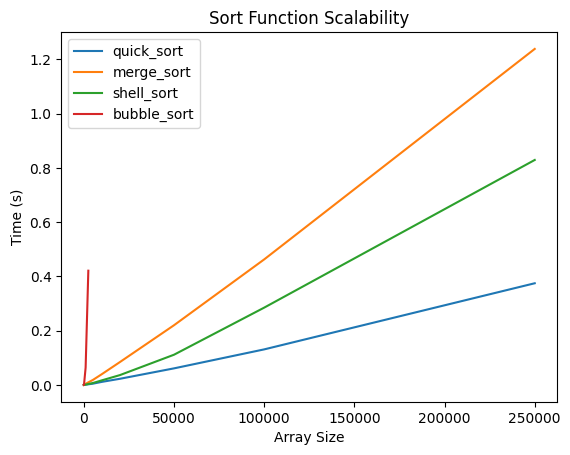

In [31]:
plt = data_frame.plot(xlabel="Array Size", ylabel="Time (s)")
plt.set_title("Sort Function Scalability")

# References

* [The `wraps` function](https://docs.python.org/3/library/functools.html#functools.wraps),
part of [the standard Python `functools` pacakge](https://docs.python.org/3/library/functools.html)
* Real Python [Primer on Python Decorators](https://realpython.com/primer-on-python-decorators/)
* [Rosetta Code](https://rosettacode.org/wiki/Rosetta_Code)
* [Project Jupyter](https://jupyter.org/)
* [SnakeViz](https://jiffyclub.github.io/snakeviz/)
* [Pandas](https://pandas.pydata.org/)
* [Matplotlib](https://matplotlib.org/)